# Prosper Loan Data
### by Hazem Samir Abdallah

## Investigation Overview

The main focus of this document is to investigate features which could possibly predict/affect loan status and borrower interest rate. Suspected variables include loan size, loan duration, Prosper rating, homeownership status, listing categories, and listing date.

## Dataset Overview

The dataset consists of 113,937 rows and 81 columns. Each row is an individual loan record. The 81 variables include loan details such as loan amount, interest rate, loan status, borrower monthly income...etc. For the sake of this project, however, only a few of those variables are considered to be the main focus.

In [1]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import squarify

%matplotlib inline

# suppress warnings from final output
import warnings
warnings.simplefilter("ignore")

In [2]:
# load in the dataset into a pandas dataframe
df = pd.read_csv('prosperLoanData.csv')

#performing several wrangling actions similar to the exploration report


#replace values, change data type and renaming of ListingCategory (numeric)
ListingCategory_dict = {0: 'Not Available',
                        1: 'Debt Consolidation',
                        2: 'Home Improvement',
                        3: 'Business',
                        4: 'Personal Loan',
                        5: 'Student Use',
                        6: 'Auto',
                        7: 'Other',
                        8: 'Baby&Adoption',
                        9: 'Boat',
                        10: 'Cosmetic Procedure',
                        11: 'Engagement Ring',
                        12: 'Green Loans',
                        13: 'Household Expenses',
                        14: 'Large Purchases',
                        15: 'Medical/Dental',
                        16: 'Motorcycle',
                        17: 'RV',
                        18: 'Taxes',
                        19: 'Vacation',
                        20: 'Wedding Loans'}

df['ListingCategory'] = df['ListingCategory (numeric)'].replace(ListingCategory_dict)
df['ListingCategory'] = df['ListingCategory'].astype('category')
df.drop(columns='ListingCategory (numeric)', inplace=True)

#change data type of ProsperRating
ProsperRating_ls = ['HR', 'E', 'D', 'C', 'B', 'A', 'AA']
ProsperRating_dtype = pd.api.types.CategoricalDtype(categories=ProsperRating_ls, ordered=True)
df['ProsperRating'] = df['ProsperRating (Alpha)'].astype(ProsperRating_dtype)
df.drop(columns='ProsperRating (Alpha)', inplace=True)

#change data type of ListingCreationDate
df.loc[:, 'ListingCreationDate'] = pd.to_datetime(df.loc[:, 'ListingCreationDate'])

#creating StatusSummary variable
LoanStatus_dict = {'Current': 'Current', 'Cancelled': 'Cancelled',
                   'Chargedoff': 'Bad Debt', 'Defaulted': 'Bad Debt',
                   'Completed': 'Completed', 'FinalPaymentInProgress': 'Completed',
                   'Past Due (1-15 days)': 'Past Due', 'Past Due (31-60 days)': 'Past Due',
                   'Past Due (61-90 days)': 'Past Due', 'Past Due (91-120 days)': 'Past Due',
                   'Past Due (16-30 days)': 'Past Due', 'Past Due (>120 days)': 'Past Due'}
df['StatusSummary'] = df['LoanStatus'].replace(LoanStatus_dict)

#creating year variable
df.loc[:, 'ListingCreationYear'] = df.loc[:, 'ListingCreationDate'].dt.year

> Note that the above cells have been set as "Skip"-type slides. That means
that when the notebook is rendered as http slides, those cells won't show up.

## Top Reasons for Obtaining Prosper Loans

Looking at the top 75-percentile of listing categories, around 1/3 of the loans is borrowed for debt consolidation purposes which is to say 50% of the total Prosper loans. Following are home improvement and business loans with less than a combined 15% of the total population. The following 10% in the top 75-percentile goes to loans requested for auto, personal, household, medical, student, taxes, weddings, and vacation purposes.

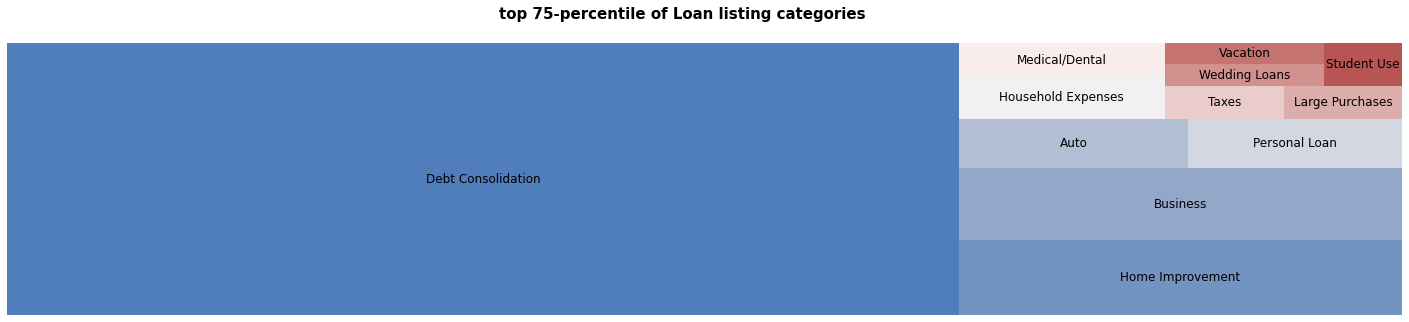

In [3]:
df_sub = df[~df.ListingCategory.isin(['Not Available', 'Other'])]

volume = df_sub.ListingCategory.value_counts().values[:12]
labels = df_sub.ListingCategory.value_counts().index[:12]
color_list = sb.color_palette('vlag', n_colors=12)

plt.figure(figsize=[25, 5])
plt.rc('font', size=12)
squarify.plot(sizes=volume, label=labels,
              color=color_list)
plt.axis('off')
plt.suptitle('top 75-percentile of Loan listing categories', fontsize = 15, weight = "bold");

## Prosper Ratings per Loan Status

There is a clear correlation between loan status and Prosper rating. Past due and bad debt loans seem to have a much lower proportion of 'AA' than current and completed loans. Overall, combined ratings between 'D' to 'HR' are significantly more evident in bad debt and past due loan listings.

*The code for the stacked chart below is referenced from Udacity classroom's following* [link](https://classroom.udacity.com/nanodegrees/nd002-ent/parts/9c2eb5bf-2bda-4e0c-85bf-d997082a8571/modules/9b9bd2f7-e891-4545-adb0-e57eb8efba81/lessons/8d08820f-00ab-4834-babd-cd33eae50104/concepts/28e18872-f2c7-4940-b9de-560c8c47a060 ).

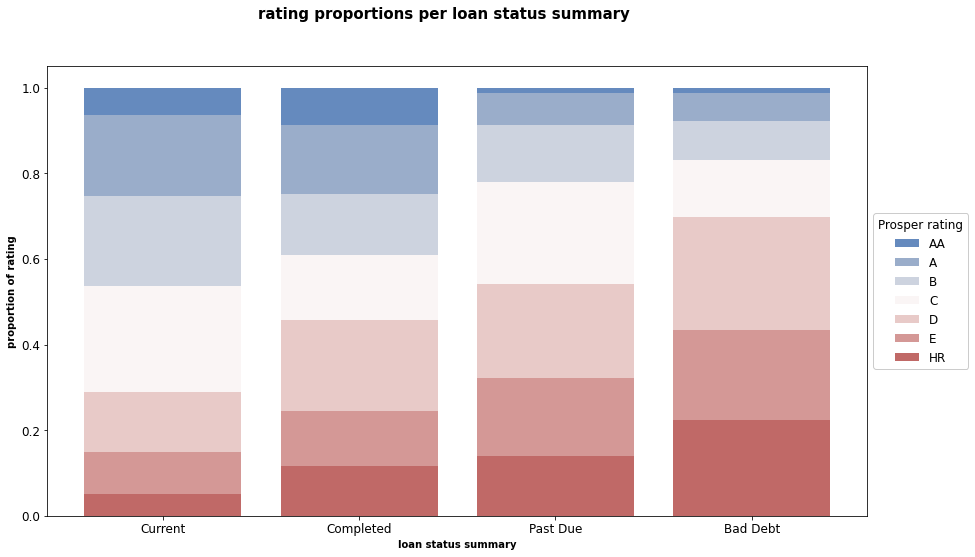

In [4]:
df_sub = df[df.ListingCreationDate > '2009-06-30'] #focusing on loans with available ratings 
status_order = ['Current', 'Completed', 'Past Due', 'Bad Debt']
rating_order = ['HR', 'E', 'D', 'C', 'B', 'A', 'AA']
color_order = sb.color_palette('vlag_r', 7)

bars_ls = []
baselines = np.zeros(len(status_order))
cat1_counts = df_sub['StatusSummary'].value_counts()

plt.figure(figsize=[14.70, 8.27])

for i in range(len(rating_order)):
    rating = rating_order[i]
    inner_counts = df_sub[df_sub['ProsperRating'] == rating]['StatusSummary'].value_counts()
    inner_props = inner_counts / cat1_counts
    
    bars = plt.bar(x = np.arange(len(status_order)),
                   height = inner_props[status_order],
                   bottom = baselines,
                   color=color_order[i])
    bars_ls.append(bars)
    baselines += inner_props[status_order]

plt.xticks(np.arange(len(status_order)), status_order)
plt.legend(reversed(bars_ls), reversed(rating_order), framealpha = 1,
           bbox_to_anchor = (1, 0.5), loc = 6, title='Prosper rating')
plt.xlabel('loan status summary', fontsize = 10, weight = "bold")
plt.ylabel('proportion of rating', fontsize = 10, weight = "bold")
plt.suptitle('rating proportions per loan status summary', fontsize = 15, weight = "bold");

## Average Interest Rates per Prosper Rating

There is a negative trend between Prosper rating and interest rate. This is simply expected considering that high risk ratings are more prone to becoming bad debts and so the cost of borrowing (i.e. interest rate) must be higher to match this high risk.

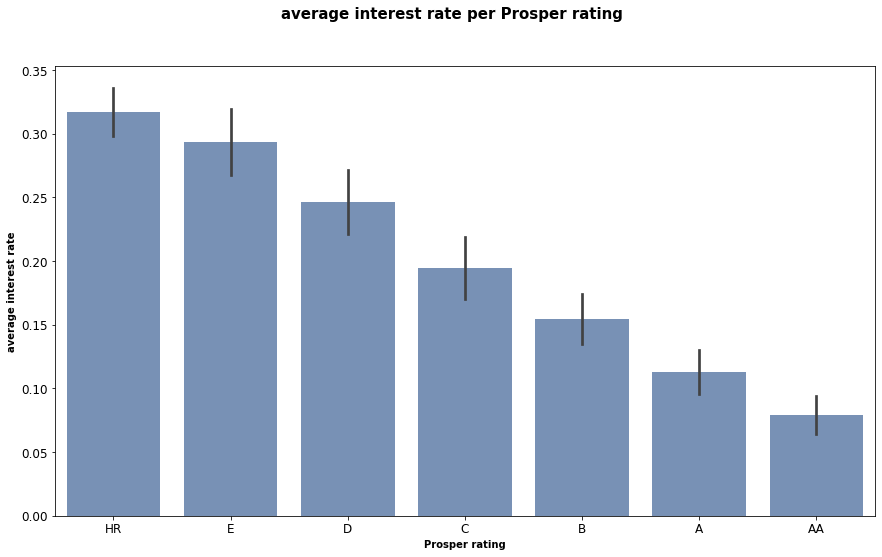

In [5]:
plt.figure(figsize=[14.70, 8.27])
base_color = sb.color_palette('vlag')[0]

sb.barplot(data=df, x='ProsperRating', y='BorrowerRate', color=base_color, ci='sd')
plt.xlabel('Prosper rating', fontsize = 10, weight = "bold")
plt.ylabel('average interest rate', fontsize = 10, weight = "bold")
plt.suptitle('average interest rate per Prosper rating', fontsize = 15, weight = "bold");

## Interet Rate and Loan Amount per Proper Rating

Two main things can be noticed from the below chart. First, high risk ratings are much more evident in small size loans. Second, for the same level of loan amount, the better the rating of a loan, the lower the borrower rate. This strengthens the relationship between interest rate and Proper ratings even further.

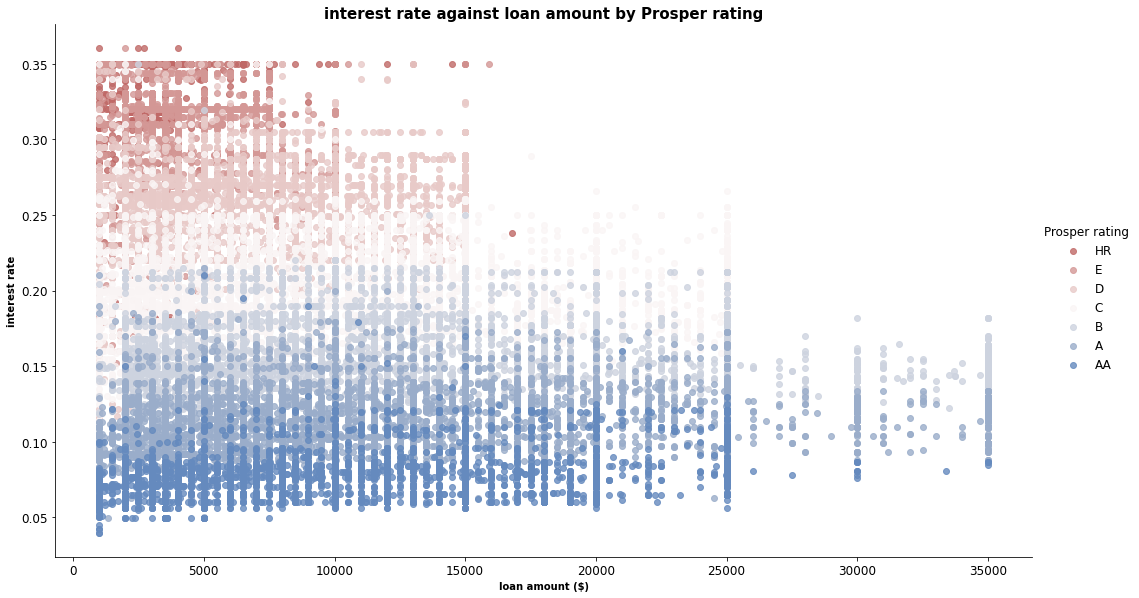

In [6]:
g = sb.FacetGrid(data = df, hue = 'ProsperRating', height = 8.27,  aspect = 14.70/8.27, palette='vlag_r')
g.map(plt.scatter, 'LoanOriginalAmount', 'BorrowerRate', alpha=0.8)
g.add_legend(title='Prosper rating')
plt.xlabel('loan amount ($)', fontsize = 10, weight = "bold")
plt.ylabel('interest rate', fontsize = 10, weight = "bold")
plt.title('interest rate against loan amount by Prosper rating', fontsize = 15, weight = "bold");

## Trend of Borrowers' Homeownership Status

The year 2009 seemes to be a turning year for homeowners. Before 2009, non-homeowning borrowers had a higher count of loan listings. After 2009, however, homeowners have a higher count and the difference keeps slightly widening from one year to another in favor of homeowners. This could be interestingly attributed to homeowners opting for loans instead of mortgage based financing following the 2008 global financial crisis. 

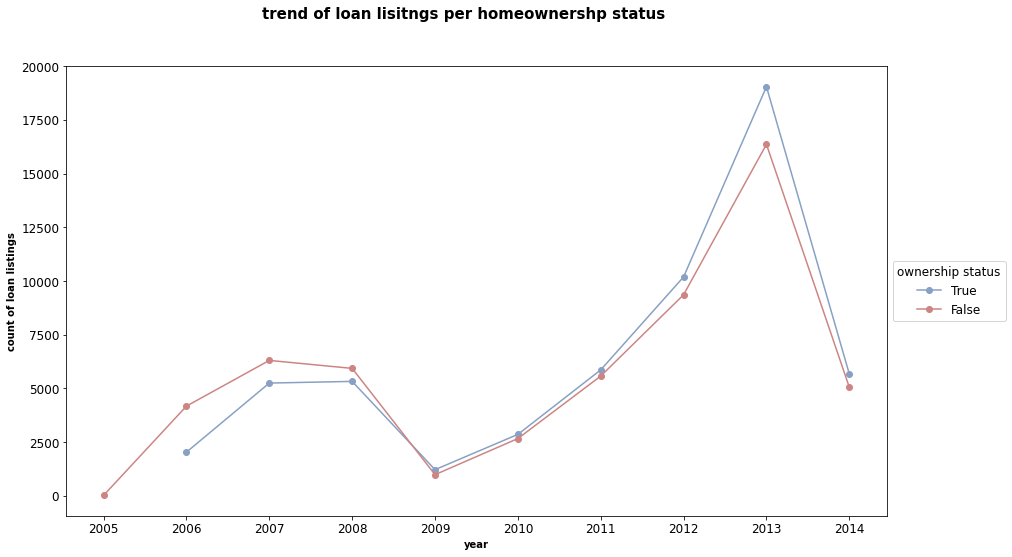

In [7]:
plt.figure(figsize=[14.70, 8.27])
colors = sb.color_palette('vlag', 4)

df_owner = df[df.IsBorrowerHomeowner == True].groupby('ListingCreationYear', as_index=False)['Term'].count()
df_nowner = df[df.IsBorrowerHomeowner == False].groupby('ListingCreationYear', as_index=False)['Term'].count()

owner = plt.plot(df_owner.ListingCreationYear, df_owner.Term, marker='o', c=colors[0])
nowner = plt.plot(df_nowner.ListingCreationYear, df_nowner.Term, marker='o', c=colors[-1])
year_ticks = np.arange(2005, 2014+1, 1)
plt.xticks(year_ticks, year_ticks)
plt.xlabel('year', fontsize = 10, weight = "bold")
plt.ylabel('count of loan listings', fontsize = 10, weight = "bold")
plt.legend(['True', 'False'], title='ownership status', bbox_to_anchor = (1, 0.5), loc=6)
plt.suptitle('trend of loan lisitngs per homeownershp status', fontsize = 15, weight = "bold");

In [8]:
!jupyter nbconvert Prosper_Loan_Data_slide_deck.ipynb --to slides --post serve  --no-input --no-prompt

[NbConvertApp] WARNING | Config option `kernel_spec_manager_class` not recognized by `NbConvertApp`.
[NbConvertApp] Converting notebook Prosper_Loan_Data_slide_deck.ipynb to slides
[NbConvertApp] Writing 1007025 bytes to Prosper_Loan_Data_slide_deck.slides.html
[NbConvertApp] Redirecting reveal.js requests to https://cdnjs.cloudflare.com/ajax/libs/reveal.js/3.5.0
Serving your slides at http://127.0.0.1:8000/Prosper_Loan_Data_slide_deck.slides.html
Use Control-C to stop this server
^C

Interrupted
